#### Question A. Which customer segments can be identified? How do you describe them in terms of their transaction behaviour (volume/value/products) and susceptibility to direct marketing? Which data (provided or recommended) could improve this segmentation?

## Importing Libraries

In [66]:
#Importing all the necessary libraries

!pip install pydotplus
!pip install imblearn

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus


from statsmodels.formula.api import ols
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
from sklearn.tree import plot_tree, export_text
from mpl_toolkits.mplot3d import Axes3D

## Loading the dataset

In [67]:
#loading transaction data
transaction_data = pd.read_csv("transaction_data.csv", low_memory=True)
transaction_data.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [68]:
#loading product data
product = pd.read_csv("product.csv", low_memory=True)
product.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [69]:
#loading campaign_table
campaign_table = pd.read_csv("campaign_table.csv", low_memory=True)
campaign_table.head()

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26


In [70]:
#loading campaign_desc
campaign_desc = pd.read_csv("campaign_desc.csv", low_memory=True)
campaign_desc.head()

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


In [71]:
#loading coupon_redempt
coupon_redempt = pd.read_csv("coupon_redempt.csv", low_memory=True)
coupon_redempt.head()

,household_key,DAY,COUPON_UPC,CAMPAIGN
0,1,421,10000085364,8
1,1,421,51700010076,8
2,1,427,54200000033,8
3,1,597,10000085476,18
4,1,597,54200029176,18


In [72]:
#loading coupon_redempt
coupon = pd.read_csv("coupon.csv", low_memory=True)
coupon.head()

,COUPON_UPC,PRODUCT_ID,CAMPAIGN
0,10000089061,27160,4
1,10000089064,27754,9
2,10000089073,28897,12
3,51800009050,28919,28
4,52100000076,28929,25


#### Finding out the number of coupons used by each household

In [73]:
household_coupon_usage = coupon_redempt.groupby('household_key').size().reset_index(name='total_coupons_used')
print("Total Number of Coupons Used by Each Household:")
print(household_coupon_usage)

Total Number of Coupons Used by Each Household:
     household_key  total_coupons_used
0                1                   5
1                8                   1
2               13                  21
3               14                   3
4               18                   8
..             ...                 ...
429           2488                  11
430           2489                  28
431           2494                   5
432           2496                  11
433           2500                   3

[434 rows x 2 columns]


## Cleaning the data

### Finding out the number od duplicate rows for each dataset

In [74]:
campaign_desc_duplicates = campaign_desc.duplicated().sum()
print(f"Campaign Description - Number of Duplicate Rows: {campaign_desc_duplicates}")


campaign_table_duplicates = campaign_table.duplicated().sum()
print(f"Campaign Table - Number of Duplicate Rows: {campaign_table_duplicates}")


product_duplicates = product.duplicated().sum()
print(f"Product - Number of Duplicate Rows: {product_duplicates}")

coupon_duplicates = coupon.duplicated().sum()
print(f"Coupon - Number of Duplicate Rows: {coupon_duplicates}")


coupon_redempt_duplicates = coupon_redempt.duplicated().sum()
print(f"Coupon Redempt - Number of Duplicate Rows: {coupon_redempt_duplicates}")


transaction_data_duplicates = transaction_data.duplicated().sum()
print(f"Transaction Data - Number of Duplicate Rows: {transaction_data_duplicates}")


Campaign Description - Number of Duplicate Rows: 0
Campaign Table - Number of Duplicate Rows: 0
Product - Number of Duplicate Rows: 0
Coupon - Number of Duplicate Rows: 5164
Coupon Redempt - Number of Duplicate Rows: 0
Transaction Data - Number of Duplicate Rows: 0


### Dropping the duplicates from the required csv files

In [75]:
coupon = coupon.drop_duplicates()

### Coercing all the data's numeric columns to only have numeric values


In [76]:
campaign_desc['START_DAY'] = pd.to_numeric(campaign_desc['START_DAY'], errors='coerce')
campaign_desc['END_DAY'] = pd.to_numeric(campaign_desc['END_DAY'], errors='coerce')
coupon_redempt['DAY'] = pd.to_numeric(coupon_redempt['DAY'], errors='coerce')
transaction_data['DAY'] = pd.to_numeric(transaction_data['DAY'], errors='coerce')
transaction_data['TRANS_TIME'] = pd.to_numeric(transaction_data['TRANS_TIME'], errors='coerce')
transaction_data['WEEK_NO'] = pd.to_numeric(transaction_data['WEEK_NO'], errors='coerce')
transaction_data['QUANTITY'] = pd.to_numeric(transaction_data['QUANTITY'], errors='coerce')
transaction_data['SALES_VALUE'] = pd.to_numeric(transaction_data['SALES_VALUE'], errors='coerce')
transaction_data['COUPON_MATCH_DISC'] = pd.to_numeric(transaction_data['COUPON_MATCH_DISC'], errors='coerce')
transaction_data['COUPON_DISC'] = pd.to_numeric(transaction_data['COUPON_DISC'], errors='coerce')
transaction_data['RETAIL_DISC'] = pd.to_numeric(transaction_data['RETAIL_DISC'], errors='coerce')

### Replacing 'Unknown' with NaN in all csv files and then also dropping all the NaN values

In [77]:
# Replacing 'Unknown' with NaN and drop rows with any NaN values for all csv files
transaction_data.replace('Unknown', np.nan, inplace=True)
transaction_data.dropna(inplace=True)

product.replace('Unknown', np.nan, inplace=True)
product.dropna(inplace=True)

campaign_table.replace('Unknown', np.nan, inplace=True)
campaign_table.dropna(inplace=True)

coupon.replace('Unknown', np.nan, inplace=True)
coupon.dropna(inplace=True)

coupon_redempt.replace('Unknown', np.nan, inplace=True)
coupon_redempt.dropna(inplace=True)

#### Standardizing all the dataset's columns to lowercase

In [78]:
# For campaign_desc
campaign_desc.columns = campaign_desc.columns.str.lower()
campaign_desc[campaign_desc.select_dtypes('object').columns] = campaign_desc.select_dtypes('object').apply(lambda x: x.str.lower())

# For campaign_table
campaign_table.columns = campaign_table.columns.str.lower()
campaign_table[campaign_table.select_dtypes('object').columns] = campaign_table.select_dtypes('object').apply(lambda x: x.str.lower())

# For product
product.columns = product.columns.str.lower()
product[product.select_dtypes('object').columns] = product.select_dtypes('object').apply(lambda x: x.str.lower())

# For transaction_data
transaction_data.columns = transaction_data.columns.str.lower()
transaction_data[transaction_data.select_dtypes('object').columns] = transaction_data.select_dtypes('object').apply(lambda x: x.str.lower())

#For coupon
coupon.columns = coupon.columns.str.lower()
coupon[coupon.select_dtypes('object').columns] = coupon.select_dtypes('object').apply(lambda x: x.str.lower())

# For coupon_redempt
coupon_redempt.columns = coupon_redempt.columns.str.lower()
coupon_redempt[coupon_redempt.select_dtypes('object').columns] = coupon_redempt.select_dtypes('object').apply(lambda x: x.str.lower())

Here we are combining all the datasets, using left join and using common columns between tables to get a single df

# Combining the dataset

In [79]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595732 entries, 0 to 2595731
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   household_key      int64  
 1   basket_id          int64  
 2   day                int64  
 3   product_id         int64  
 4   quantity           int64  
 5   sales_value        float64
 6   store_id           int64  
 7   retail_disc        float64
 8   trans_time         int64  
 9   week_no            int64  
 10  coupon_disc        float64
 11  coupon_match_disc  float64
dtypes: float64(4), int64(8)
memory usage: 237.6 MB


In [80]:
transaction_data.shape

(2595732, 12)

In [81]:
# Join 1: Adding coupon_redempt to transaction data on 'household_key' and 'day'
transaction_couponredempt = pd.merge(transaction_data, coupon_redempt, on=['household_key', 'day'], how='left')
transaction_couponredempt.shape

(2648695, 14)

In [82]:
# Join 2: Adding product on 'product_id' to the previous combined datasets
transaction_couponredempt_product = pd.merge(transaction_couponredempt, product, on='product_id', how='left')
transaction_couponredempt_product.shape

(2648695, 20)

In [83]:
# Join  3: Adding campaign_desc on 'campaign' to the precious combined datasets
transaction_couponredempt_product_campaign = pd.merge(transaction_couponredempt_product, campaign_desc, on='campaign', how='left')

In [84]:
transaction_couponredempt_product_campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2648695 entries, 0 to 2648694
Data columns (total 23 columns):
 #   Column                Dtype  
---  ------                -----  
 0   household_key         int64  
 1   basket_id             int64  
 2   day                   int64  
 3   product_id            int64  
 4   quantity              int64  
 5   sales_value           float64
 6   store_id              int64  
 7   retail_disc           float64
 8   trans_time            int64  
 9   week_no               int64  
 10  coupon_disc           float64
 11  coupon_match_disc     float64
 12  coupon_upc            float64
 13  campaign              float64
 14  manufacturer          int64  
 15  department            object 
 16  brand                 object 
 17  commodity_desc        object 
 18  sub_commodity_desc    object 
 19  curr_size_of_product  object 
 20  description           object 
 21  start_day             float64
 22  end_day               float64
dtypes: floa

In [85]:
df = transaction_couponredempt_product_campaign

#Feature Extraction

Creating the Loyaly_Card_Price Column and Non_Loyalty_Card_Price_Colummn

In [86]:
# First we need to replace any 0 with NaN to avoid division errors
df['quantity'] = df['quantity'].replace(0, np.nan)

#Now we will calculate the loyalty_card_price and non_loyalty_Card_price
df['loyalty_card_price'] = (df['sales_value'] - (df['retail_disc'] + df['coupon_match_disc'])) / df['quantity']
df['non_loyalty_card_price'] = (df['sales_value'] - df['coupon_match_disc']) / df['quantity']

Calculating total spending by each household using loyal card price

In [87]:
# Calculating Total Spending by Household
total_spending = (
    df.groupby('household_key')['loyalty_card_price']
    .sum()
    .reset_index()
    .rename(columns={'loyalty_card_price': 'total_spending'})
)

Calculating the purchase frequency for each household

In [88]:
# Calculating Purchase Frequency by Household
purchase_frequency = (
    df.groupby('household_key')['basket_id']
    .nunique()
    .reset_index()
    .rename(columns={'basket_id': 'purchase_frequency'})
)


Calculating Unique Campaign that that are redeemed

In [89]:
# Grouping by 'household_key' and 'campaign' to identify if any coupon was redeemed
campaign_redemption_status = (
    coupon_redempt.groupby(['household_key', 'campaign'])
    .agg(redeemed=('coupon_upc', lambda x: x.notnull().any()))  # Check if any coupon was redeemed
    .reset_index()
)

# Counting the number of campaigns with at least one redemption per household
unique_campaigns_used = (
    campaign_redemption_status[campaign_redemption_status['redeemed']]
    .groupby('household_key')['campaign']
    .nunique()  # Count unique campaigns with redemptions
    .reset_index()
)

# Renaming columns for clarity
unique_campaigns_used.rename(columns={'campaign': 'unique_campaigns_with_redemptions'}, inplace=True)

unique_campaigns_used.head()

,household_key,unique_campaigns_with_redemptions
0,1,2
1,8,1
2,13,7
3,14,1
4,18,3


In [90]:
# Checking for NaN values in unique_campaigns_use
na_values_unique_campaigns_used = unique_campaigns_used.isna().sum()
print("Missing values in unique_campaigns_used:\n", na_values_unique_campaigns_used)

Missing values in unique_campaigns_used:
 household_key                        0
unique_campaigns_with_redemptions    0
dtype: int64


In [91]:
# Calculating the total campaign exposure per household
campaign_exposure = (
    campaign_table.groupby('household_key')['campaign']
    .nunique()
    .reset_index()
    .rename(columns={'campaign': 'campaigns_exposed'})
)

In [92]:
# Checking for NaN values in campaign_exposure
na_values_campaign_exposure = campaign_exposure.isna().sum()
print("Missing values in campaign_exposure:\n", na_values_campaign_exposure)

Missing values in campaign_exposure:
 household_key        0
campaigns_exposed    0
dtype: int64


Merging campaign exposure and unique campaign used used to calculate response rate to coupons

In [93]:
# Merging campaign exposure and unique campaign used used to calculate response rate to coupons
campaign_engagement = pd.merge(campaign_exposure, unique_campaigns_used, on='household_key', how='left')

In [94]:
# Calculating response rate
campaign_engagement['response_rate'] = campaign_engagement['unique_campaigns_with_redemptions'] / campaign_engagement['campaigns_exposed']

Combing all the extracted features in a dataset called features to carry out clustering

In [95]:
grouped = (
    purchase_frequency
    .merge(total_spending, on='household_key', how='left')
    .merge(campaign_engagement[['household_key', 'unique_campaigns_with_redemptions', 'response_rate']], on='household_key', how='left')
)

# Filling missing values with 0
grouped.fillna(0, inplace=True)

# Selecting features
features = ['purchase_frequency', 'total_spending', 'response_rate']
grouped_features = grouped[['household_key'] + features]

# Now we can perform clustering analysis on features

## K-Means Clustering

In [96]:
# Data Standardization
scaler = StandardScaler()
data_scaled = scaler.fit_transform(grouped[features])

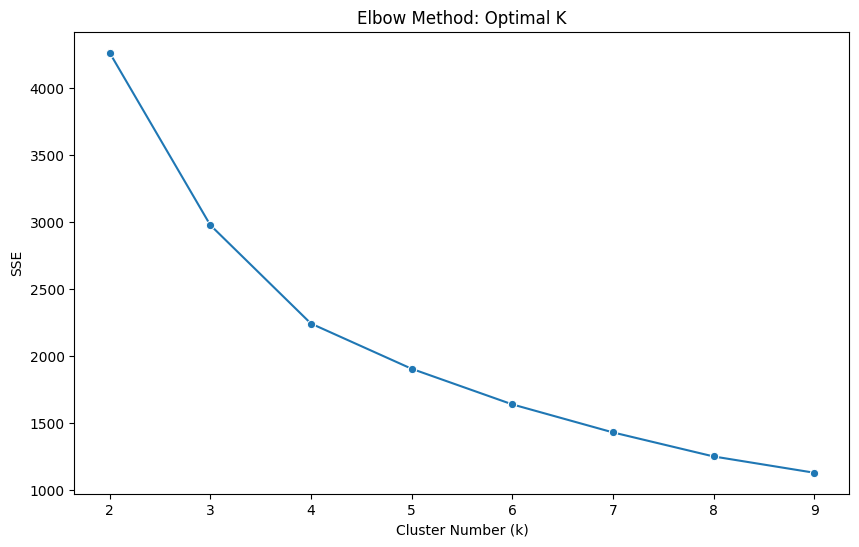

In [97]:
# Initialize dictionaries to store SSE and Silhouette Scores
SSE = {}
silhouette_scores = {}

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(data_scaled)
    SSE[k] = kmeans.inertia_
    silhouette_scores[k] = silhouette_score(data_scaled, kmeans.labels_)

# Plot the Elbow Method (SSE)
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(SSE.keys()), y=list(SSE.values()), marker='o')
plt.title("Elbow Method: Optimal K")
plt.xlabel("Cluster Number (k)")
plt.ylabel("SSE")
plt.show()

By seeing the above graph we see the elbow occours at 3 and 4, but to select a single feature we wil carry find out silhouette scores to find the optimal level of k

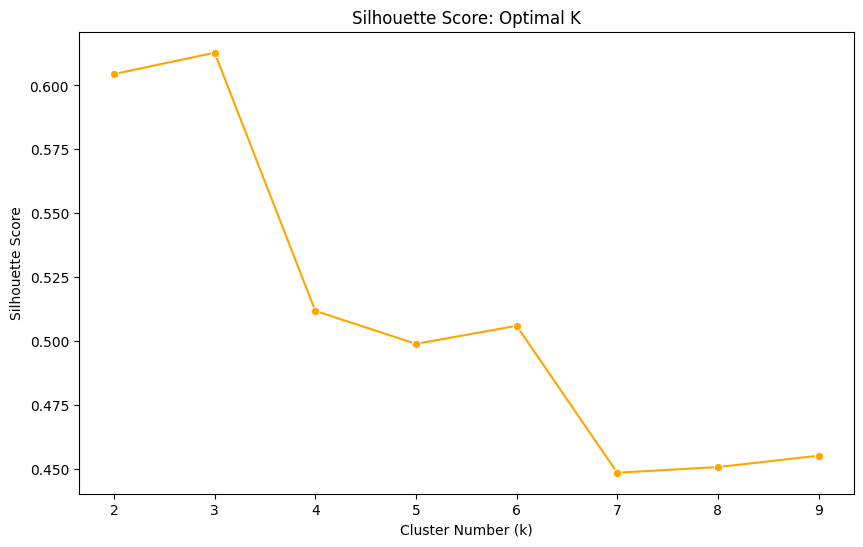

In [98]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(silhouette_scores.keys()), y=list(silhouette_scores.values()), marker='o', color='orange')
plt.title("Silhouette Score: Optimal K")
plt.xlabel("Cluster Number (k)")
plt.ylabel("Silhouette Score")
plt.show()

In [99]:
print("Silhouette Scores for Different K:")
for k, score in silhouette_scores.items():
    print(f"K={k}: Silhouette Score={score:.4f}")

Silhouette Scores for Different K:
K=2: Silhouette Score=0.6045
K=3: Silhouette Score=0.6128
K=4: Silhouette Score=0.5118
K=5: Silhouette Score=0.4990
K=6: Silhouette Score=0.5060
K=7: Silhouette Score=0.4486
K=8: Silhouette Score=0.4508
K=9: Silhouette Score=0.4552


Silhouette Score=0.6128 is the highest silhouette score value and occours at K=3, hence we will select k=3

Clustering with K=3

In [100]:
# K-means clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(data_scaled)
grouped['kmeans'] = kmeans.labels_

# Adding these cluster labels to the original dataset
grouped['cluster'] = kmeans.labels_

In [101]:
# Aggregating the features of each cluster
cluster = grouped.groupby('kmeans')[features].mean()
print(cluster)

        purchase_frequency  total_spending  response_rate
kmeans                                                   
0                70.916971     1797.517377       0.006157
1               141.784038     5122.268274       0.555947
2               296.983871     7981.048884       0.090316


We find out three disctinct clusters on the basis of purchase frequency, total spending and response rate of clusters

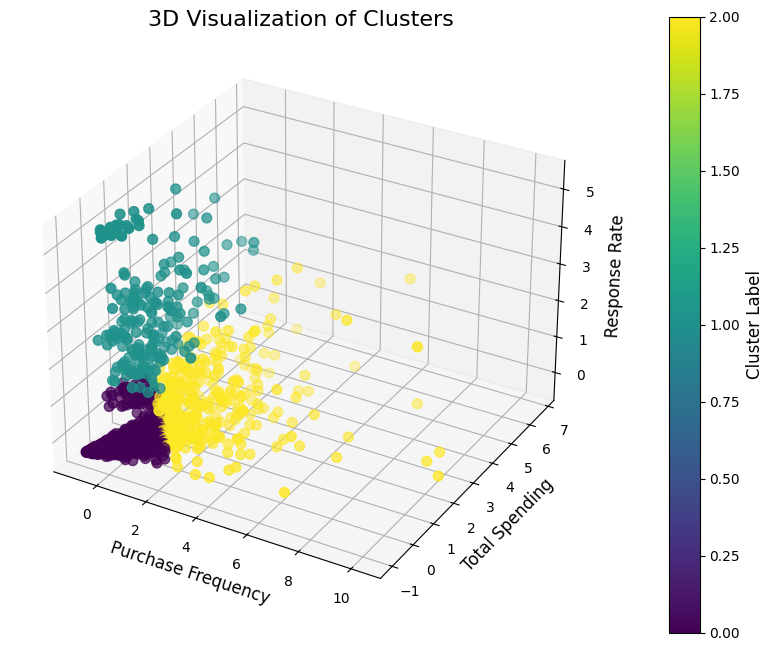

In [102]:
x = data_scaled[:, 0]
y = data_scaled[:, 1]
z = data_scaled[:, 2]

# Getting cluster labels from kmeans
labels = kmeans.labels_

# Creating a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for each cluster
scatter = ax.scatter(x, y, z, c=labels, cmap='viridis', s=50)

# Adding titles and labels
ax.set_title('3D Visualization of Clusters', fontsize=16)
ax.set_xlabel('Purchase Frequency', fontsize=12)
ax.set_ylabel('Total Spending', fontsize=12)
ax.set_zlabel('Response Rate', fontsize=12)

# Color bar to indicate cluster labels
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cluster Label', fontsize=12)

plt.show()

But the values need to descaled, to make valuable infereneces

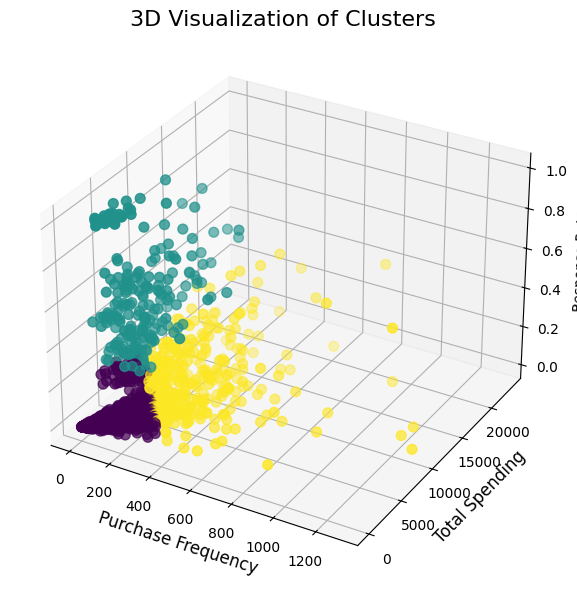

In [104]:
# Descaleing  the features so the plot makes sense
descaled_data = scaler.inverse_transform(data_scaled)

# Extracting descaled values for the first three features
x = descaled_data[:, 0]  # Purchase Frequency (descaled)
y = descaled_data[:, 1]  # Total Spending (descaled)
z = descaled_data[:, 2]  # Response Rate (descaled)

# Getting cluster labels from kmeans
labels = kmeans.labels_

# Creating a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for each cluster
scatter = ax.scatter(x, y, z, c=labels, cmap='viridis', s=50)

# Adding titles and labels
ax.set_title('3D Visualization of Clusters', fontsize=16)
ax.set_xlabel('Purchase Frequency', fontsize=12)
ax.set_ylabel('Total Spending', fontsize=12)
ax.set_zlabel('Response Rate', fontsize=10)

plt.tight_layout()

plt.show()

## Classification Tree Clustering

Coupon Redemption Calculation - Used as Classification Tree Outcome Variable

In [105]:
########## Using UPC To Calculate Count of Coupon Redemption
# Grouping by 'household_key' and count the number of 'coupon_upc' for each household
coupon_redemption = coupon_redempt.groupby('household_key')['coupon_upc'].count()

# Resetting index to make it a DataFrame
coupon_redemption = coupon_redemption.reset_index()

# Renaming columns for clarity
coupon_redemption.columns = ['household_key', 'coupon_redemption']

# Sorting the DataFrame by 'coupon_redemption' in descending order
coupon_redemption = coupon_redemption.sort_values(by='coupon_redemption', ascending=False)

print(coupon_redemption)

     household_key  coupon_redemption
69             367                 35
48             256                 33
13              67                 33
306           1823                 30
161            931                 29
..             ...                ...
321           1928                  1
86             460                  1
323           1936                  1
215           1326                  1
179           1012                  1

[434 rows x 2 columns]


Binning of Coupon Frequency

In [106]:
print(coupon_redemption['coupon_redemption'].unique())

[35 33 30 29 28 27 25 23 22 21 20 19 17 16 15 14 13 12 11 10  9  8  7  6
  5  4  3  2  1]


In [107]:
# Binning the coupon redemption count into 2 bins
coupon_redemption['coupon_redemption_bin_freq'] = pd.qcut(
    coupon_redemption['coupon_redemption'],
    q=2,
    labels=['Q1', 'Q2'],  # One fewer label than bins
    duplicates='drop'
)


print(coupon_redemption.head())

     household_key  coupon_redemption coupon_redemption_bin_freq
69             367                 35                         Q2
48             256                 33                         Q2
13              67                 33                         Q2
306           1823                 30                         Q2
161            931                 29                         Q2


In [108]:
# Displaying the unique values within each bin, sorted from low to high
for label in coupon_redemption['coupon_redemption_bin_freq'].unique():
    print(f"Bin: {label}")

    # Getting the coupon redemption values for the current bin, sorted from low to high
    sorted_values = coupon_redemption[coupon_redemption['coupon_redemption_bin_freq'] == label]['coupon_redemption'].sort_values()

    # Printting the sorted values
    print(sorted_values.values)
    print('-' * 40)

print(coupon_redemption[['household_key', 'coupon_redemption', 'coupon_redemption_bin_freq']].head())


Bin: Q2
[ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9
  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 13 13 13 13 14 14 14 14 15
 15 15 15 16 16 17 19 19 19 19 20 20 21 21 21 22 23 23 23 23 23 25 25 27
 28 28 28 29 30 33 33 35]
----------------------------------------
Bin: Q1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

Departmental/Produce Category Breakdown of Customer Spending

In [109]:
print(df['department'].unique())

['produce' 'grocery' 'drug gm' 'meat' 'meat-pckgd' 'deli' 'seafood-pckgd'
 ' ' 'pastry' 'nutrition' 'video rental' 'misc sales tran' 'floral'
 'seafood' 'salad bar' 'automotive' 'spirits' 'cosmetics' 'misc. trans.'
 'garden center' 'chef shoppe' 'travel & leisur' 'coup/str & mfg'
 'kiosk-gas' 'frozen grocery' 'restaurant' 'housewares' 'pork'
 'postal center' 'gm merch exp' 'cntrl/store sup' 'prod-whs sales'
 'dairy deli' 'hbc' 'charitable cont' 'rx' 'toys' 'photo' 'deli/snack bar'
 'gro bakery' 'pharmacy supply' 'elect &plumbing' 'meat-whse' 'video']


In [110]:
# Mapping of departments to their respective categories
department_to_category = {
    'toys': 'Toys and Entertainment',
    'video': 'Toys and Entertainment',
    'video rental': 'Toys and Entertainment',
    'travel & leisur': 'Toys and Entertainment',

    ' ': 'Miscellaneous',
    'restaurant': 'Miscellaneous',
    'coup/str & mfg': 'Miscellaneous',
    'gm merch exp': 'Miscellaneous',
    'misc sales tran': 'Miscellaneous',
    'misc. trans.': 'Miscellaneous',
    'photo': 'Miscellaneous',
    'postal center': 'Miscellaneous',
    'charitable cont': 'Miscellaneous',
    'cntrl/store sup': 'Miscellaneous',

    'cosmetics': 'Health and Wellness',
    'drug gm': 'Health and Wellness',
    'hbc': 'Health and Wellness',
    'nutrition': 'Health and Wellness',
    'pharmacy supply': 'Health and Wellness',
    'rx': 'Health and Wellness',

    'elect &plumbing': 'Household and Kitchen Supplies',
    'floral': 'Household and Kitchen Supplies',
    'garden center': 'Household and Kitchen Supplies',
    'housewares': 'Household and Kitchen Supplies',

    'dairy deli': 'Grocery',
    'deli': 'Grocery',
    'deli/snack bar': 'Grocery',
    'frozen grocery': 'Grocery',
    'gro bakery': 'Grocery',
    'grocery': 'Grocery',
    'meat': 'Grocery',
    'meat-pckgd': 'Grocery',
    'meat-whse': 'Grocery',
    'pastry': 'Grocery',
    'pork': 'Grocery',
    'produce': 'Grocery',
    'salad bar': 'Grocery',
    'seafood': 'Grocery',
    'seafood-pckgd': 'Grocery',
    'spirits': 'Grocery',
    'prod-whs sales': 'Grocery',
    'chef shoppe': 'Grocery',

    'kiosk-gas': 'Automotive',
    'automotive': 'Automotive',
}

# Creating a new column 'category' based on the department
def categorize_department(department):
    return department_to_category.get(department, 'Other')  # Default to 'Other' if not mapped

# Applying the categorization function to the department column
df['category'] = df['department'].apply(lambda x: categorize_department(x))

# Aggregating amount paid (loyalty_card_price) by household and category
category_sales = (
    df.groupby(['household_key', 'category'])['loyalty_card_price']
    .sum()
    .reset_index()
)

# Pivoting the data to create columns for each category
category_pivot = category_sales.pivot(
    index='household_key',
    columns='category',
    values='loyalty_card_price'
).fillna(0)  # Fill NaN with 0 for categories not purchased

# Resetting index to merge back with the main dataset
category_pivot.reset_index(inplace=True)

# Renaming columns for clarity
category_pivot.columns.name = None  # Remove hierarchical naming from pivot
category_pivot = category_pivot.rename(
    columns={col: f"sales_{col.lower().replace(' ', '_')}" for col in category_pivot.columns if col != 'household_key'}
)


print(category_pivot)


      household_key  sales_automotive  sales_grocery  \
0                 1          0.000000    4124.638333   
1                 2          0.000000    1686.030000   
2                 3          0.002979    2093.045833   
3                 4          0.000000     789.070000   
4                 5          0.000000     614.900000   
...             ...               ...            ...   
2495           2496         20.039850    4759.080000   
2496           2497         10.010616    5661.329962   
2497           2498          0.000000    2222.210000   
2498           2499          0.009048    2700.958333   
2499           2500          0.034856    3302.681667   

      sales_health_and_wellness  sales_household_and_kitchen_supplies  \
0                    602.670000                                  7.99   
1                    357.760000                                 21.99   
2                    149.585000                                  0.00   
3                    312.970000    

Join data needed for Classification Tree

In [111]:
# Merging the category preferences pivot with the coupon_redemption on 'household_key'
merged_df = pd.merge(category_pivot, coupon_redemption, on='household_key', how='left')

print(merged_df.head())

   household_key  sales_automotive  sales_grocery  sales_health_and_wellness  \
0              1          0.000000    4124.638333                    602.670   
1              2          0.000000    1686.030000                    357.760   
2              3          0.002979    2093.045833                    149.585   
3              4          0.000000     789.070000                    312.970   
4              5          0.000000     614.900000                    226.670   

   sales_household_and_kitchen_supplies  sales_miscellaneous  \
0                                  7.99                24.17   
1                                 21.99                 2.13   
2                                  0.00                 0.00   
3                                  0.00                 0.00   
4                                  0.00                 0.00   

   sales_toys_and_entertainment  coupon_redemption coupon_redemption_bin_freq  
0                           0.0                5.0    

In [112]:
# Adding 'Q0' as a new category as without we received error over traceback "TypeError: Cannot setitem on a Categorical with a new category (Q0), set the categories first"
merged_df['coupon_redemption_bin_freq'] = merged_df['coupon_redemption_bin_freq'].cat.add_categories('Q0')

# Replacing NaN values with 'Q0'
merged_df['coupon_redemption_bin_freq'] = merged_df['coupon_redemption_bin_freq'].fillna('Q0')

# Displaying the updated DataFrame to verify the changes
print(merged_df['coupon_redemption_bin_freq'])

0       Q2
1       Q0
2       Q0
3       Q0
4       Q0
        ..
2495    Q2
2496    Q0
2497    Q0
2498    Q0
2499    Q1
Name: coupon_redemption_bin_freq, Length: 2500, dtype: category
Categories (3, object): ['Q1' < 'Q2' < 'Q0']


Counting Count of each category

In [113]:
category_counts = merged_df['coupon_redemption_bin_freq'].value_counts()
print(category_counts)

coupon_redemption_bin_freq
Q0    2066
Q1     234
Q2     200
Name: count, dtype: int64


In [114]:
# Check no nulls are present in key variables (non binned coupon_redemption will not be used in analysis)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   household_key                         2500 non-null   int64   
 1   sales_automotive                      2500 non-null   float64 
 2   sales_grocery                         2500 non-null   float64 
 3   sales_health_and_wellness             2500 non-null   float64 
 4   sales_household_and_kitchen_supplies  2500 non-null   float64 
 5   sales_miscellaneous                   2500 non-null   float64 
 6   sales_toys_and_entertainment          2500 non-null   float64 
 7   coupon_redemption                     434 non-null    float64 
 8   coupon_redemption_bin_freq            2500 non-null   category
dtypes: category(1), float64(7), int64(1)
memory usage: 158.9 KB


CLASSIFICATION MODEL ITSELF

In [115]:
y = merged_df['coupon_redemption_bin_freq']
X =merged_df.drop(['coupon_redemption_bin_freq','household_key','coupon_redemption'],axis=1)

X.dtypes

,0
sales_automotive,float64
sales_grocery,float64
sales_health_and_wellness,float64
sales_household_and_kitchen_supplies,float64
sales_miscellaneous,float64
sales_toys_and_entertainment,float64


In [116]:
# Applying label encoding directly on the target variable 'coupon_redemption_bin_freq'
y = LabelEncoder().fit_transform(y)

y[:5]

array([2, 0, 0, 0, 0])

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

decision_tree = DecisionTreeClassifier(random_state=42,class_weight='balanced')
decision_tree.fit(X_train, y_train)
prediction = decision_tree.predict(X_test)

# Predicting probabilities for each class
prediction_proba = decision_tree.predict_proba(X_test)

# Evaluating the model
print('Accuracy:', accuracy_score(y_test, prediction))
print('AUC (Macro-Averaged):', roc_auc_score(y_test, prediction_proba, multi_class='ovr', average='macro'))
print('Number of nodes:', decision_tree.tree_.node_count)

Accuracy: 0.772
AUC (Macro-Averaged): 0.6177809798372306
Number of nodes: 723


In [118]:
decision_tree2 = DecisionTreeClassifier(max_depth=4,min_samples_leaf=10,criterion='entropy', random_state=42, class_weight='balanced')
decision_tree2.fit(X_train,y_train)
prediction = decision_tree2.predict(X_test)

# Predicting probabilities for each class
y_prob = decision_tree2.predict_proba(X_test)

# Evaluating the model
print('Accuracy:', accuracy_score(y_test, prediction))
print('AUC (Macro-Averaged):', roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro'))
print('Number of nodes:', decision_tree2.tree_.node_count)

Accuracy: 0.724
AUC (Macro-Averaged): 0.7895002143451987
Number of nodes: 29


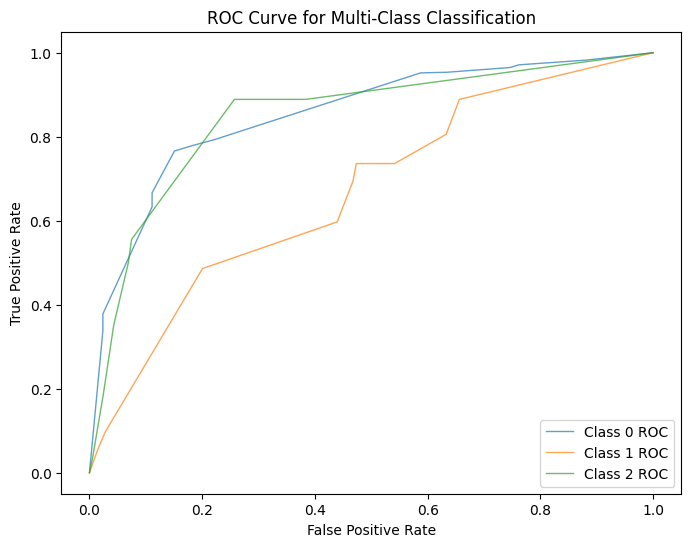

In [119]:
# Predicted probabilities for each class
prediction_proba = decision_tree2.predict_proba(X_test)


plt.figure(figsize=(8, 6))

# Computing ROC curve for each class
for i in range(len(decision_tree2.classes_)):
    fpr, tpr, thresholds = roc_curve(y_test == decision_tree2.classes_[i], prediction_proba[:, i])
    plt.plot(fpr, tpr, lw=1, alpha=0.7, label=f'Class {decision_tree2.classes_[i]} ROC')

# Plotting formatting
plt.title('ROC Curve for Multi-Class Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [121]:
##### UNDERSAMPLING

if isinstance(y_train, pd.Series):
    y_train = y_train.to_numpy()

# Separating majority and minority indices
majority_indices = np.where(y_train == 0)[0]  # '0' is the label for Q0 (majority class)
minority_indices = np.where(y_train != 0)[0]  # All other classes

# Undersampling majority class
undersampled_majority_indices = resample(
    majority_indices,
    replace=False,  # Sample without replacement
    n_samples=len(minority_indices),  # Match minority class size
    random_state=42
)

# Combining undersampled majority indices with all minority indices
undersampled_indices = np.concatenate([undersampled_majority_indices, minority_indices])

# Need positional indexing, otherwise an error is received
X_train_undersampled = X_train.iloc[undersampled_indices]
y_train_undersampled = y_train[undersampled_indices]

# Verifying class distribution
(unique, counts) = np.unique(y_train_undersampled, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution after undersampling:", class_distribution)


decision_tree_undersampled = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, criterion='entropy', random_state=42)
decision_tree_undersampled.fit(X_train_undersampled, y_train_undersampled)
prediction_undersampled = decision_tree_undersampled.predict(X_test)

# Predicting probabilities for each class
y_prob_undersampled = decision_tree_undersampled.predict_proba(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, prediction_undersampled))
print("AUC (Macro-Averaged):", roc_auc_score(y_test, y_prob_undersampled, multi_class='ovr', average='macro'))
print("Number of nodes:", decision_tree_undersampled.tree_.node_count)

Class distribution after undersampling: {0: 308, 1: 162, 2: 146}
Accuracy: 0.7413333333333333
AUC (Macro-Averaged): 0.8122181265072164
Number of nodes: 27


In [122]:
#### SMOTE SMOTE SMOTE SMOTE

# Applying SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verifying  class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

decision_tree_SMOTE = DecisionTreeClassifier(max_depth=4,min_samples_leaf=10,criterion='entropy', random_state=42)
decision_tree_SMOTE.fit(X_train_smote,y_train_smote)
prediction = decision_tree_SMOTE.predict(X_test)

# Predicting probabilities for each class
y_prob_SMOTE = decision_tree_SMOTE.predict_proba(X_test)

# Evaluating the model
print('Accuracy:', accuracy_score(y_test, prediction))
print('AUC (Macro-Averaged):', roc_auc_score(y_test, y_prob_SMOTE, multi_class='ovr', average='macro'))
print('Number of nodes:', decision_tree_SMOTE.tree_.node_count)

Class distribution after SMOTE:
0    1442
1    1442
2    1442
Name: count, dtype: int64
Accuracy: 0.664
AUC (Macro-Averaged): 0.8218013127250066
Number of nodes: 29


CLASSIFICATION TREE VISUAL

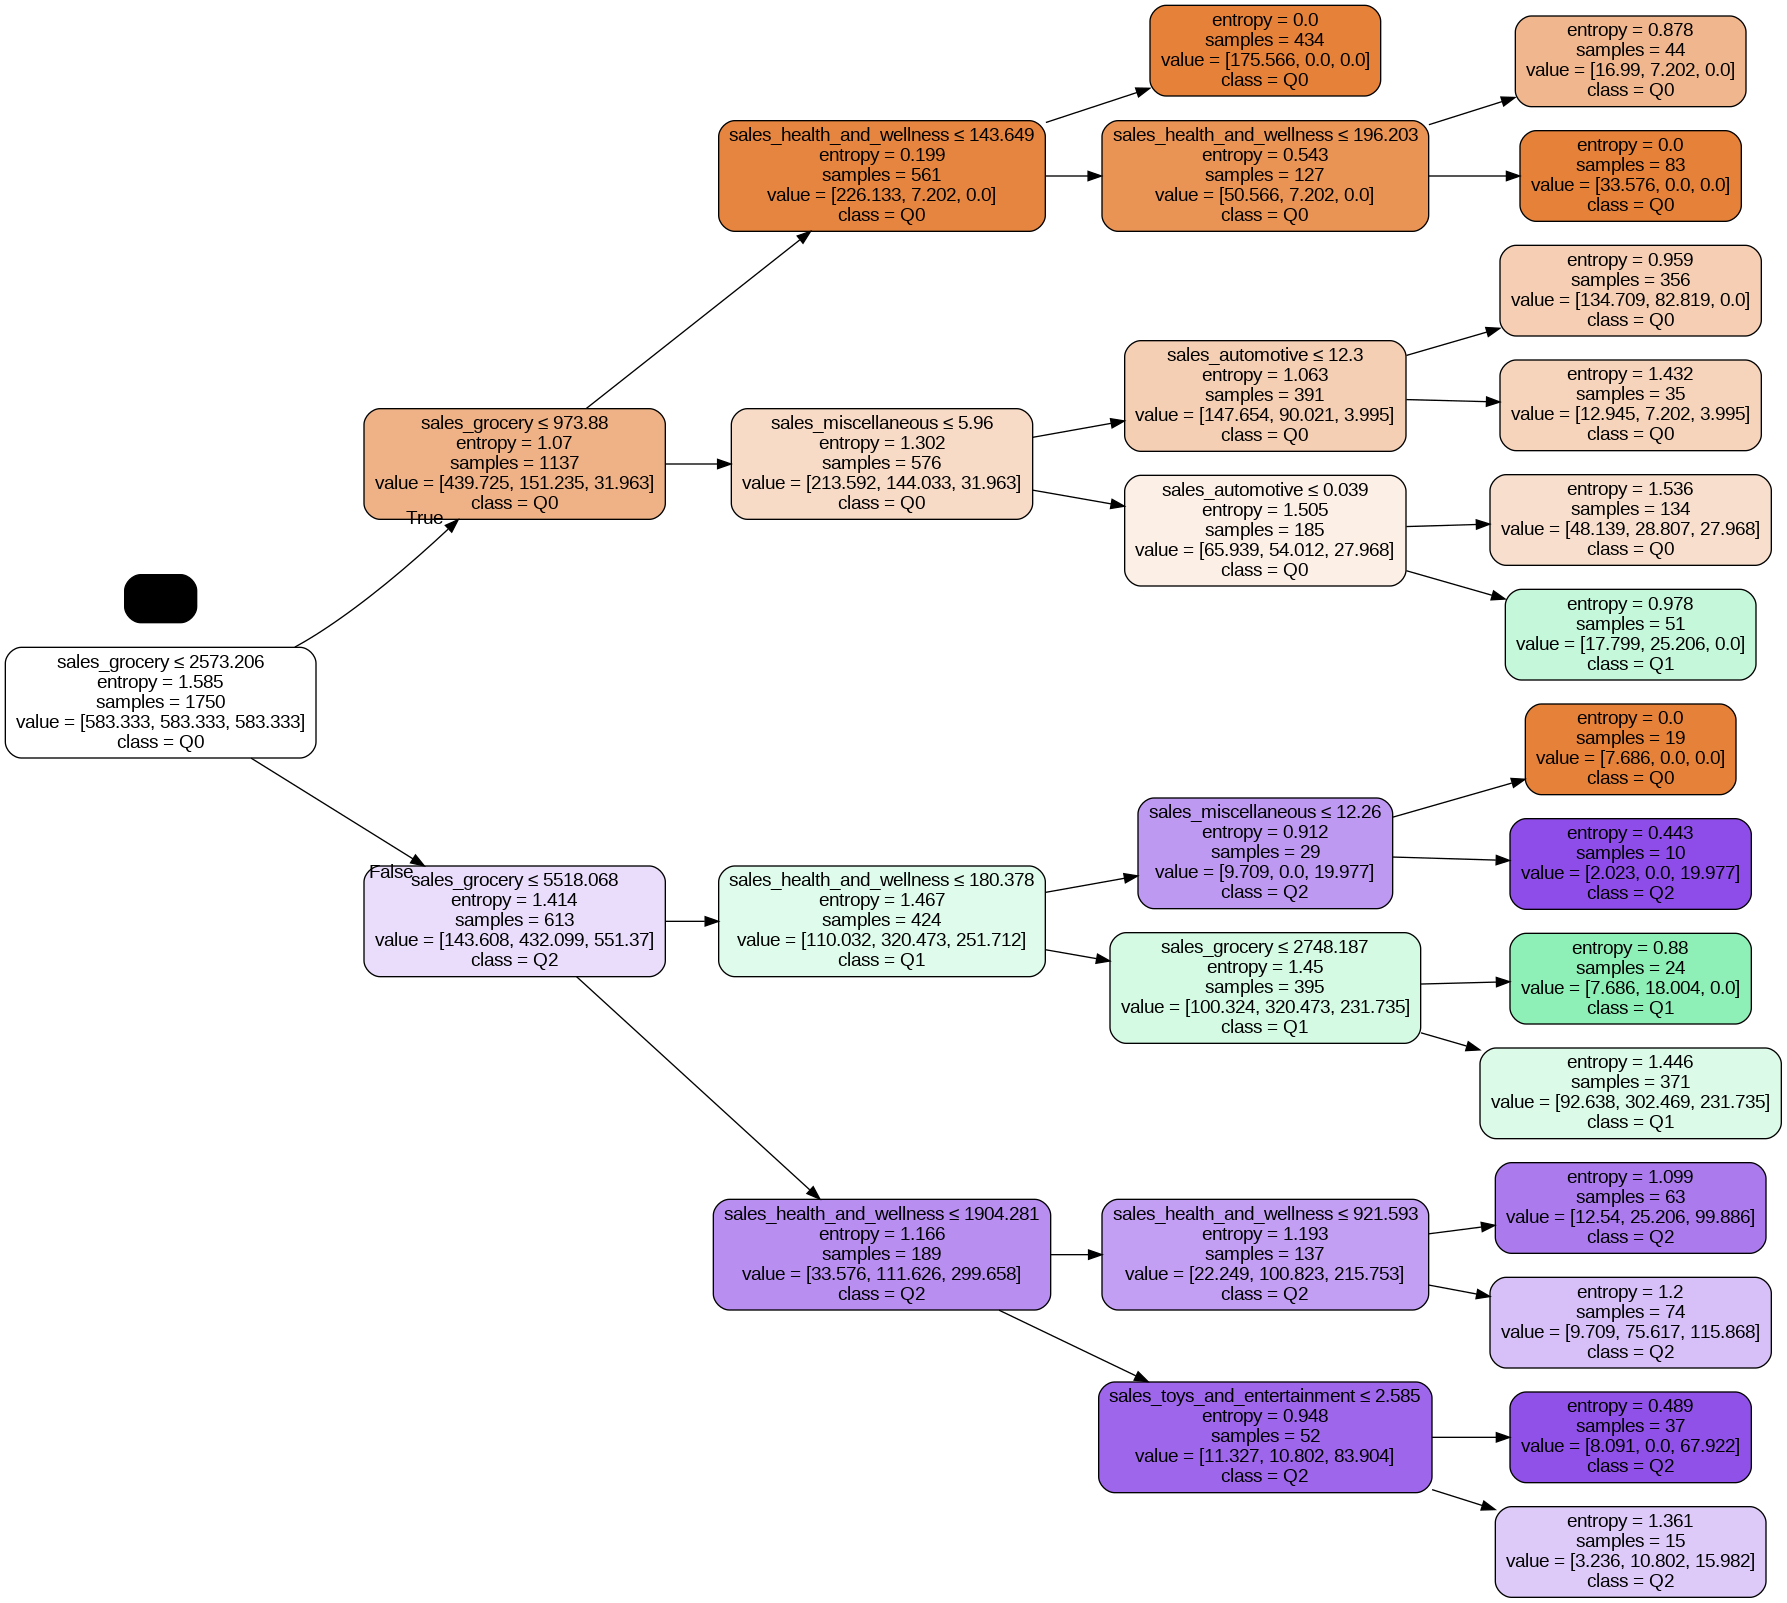

In [123]:
# Visual of Model 2 with balanced bin weights

# Specifying the class names for your multi-class target variable
class_names = ['Q0', 'Q1', 'Q2']

# Creating a file to store the figure in
dot_data = StringIO()

# Exporting the decision tree
#42
export_graphviz(decision_tree2, out_file=dot_data,
                filled=True, rounded=True,
                class_names=class_names,  # Class names from coupon_redemption_bin_freq
                special_characters=True,
                feature_names=X.columns,  # Feature names from your X dataset
                rotate=True)

# Importing and displaying the figure
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())  # Displaying the image
